# Modelado Final: Comparación de Modelos y Ensambles  
Implementación de modelos de regresión para predecir **ventas mensuales** en el contexto de retail.  
Se pone a prueba la técnica de ensamble, evaluando su desempeño con métricas clave.

## **Objetivos**
- Implementar modelos individuales y de ensamble.  
- Evaluar su desempeño en términos de error y precisión.  
- Identificar el modelo óptimo para la predicción de ventas.  
- Visualizar la importancia de características y los resultados obtenidos.  


In [28]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler



## Carga y Preparación de Datos  
Se importan los datos desde un archivo CSV, eliminando valores nulos y seleccionando las variables relevantes para el análisis.

In [29]:
# Cargamos y preparar los datos
df = pd.read_csv('datos_retail_trans.csv')
df.dropna(inplace=True)

# Seleccionamos las variables numéricas
X = df.select_dtypes(include=['number']).drop(columns=['venta_mensual'])  # Variables predictoras
y = df['venta_mensual']  # Variable objetivo

# Dividimos datos en entrenamiento y prueba (80% entrenamiento y 20% para prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizamos características numéricas para modelos sensibles a escala
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelos Individuales  
En esta sección se entrenan los siguientes modelos:
- **Regresión Lineal:** Modelo base para evaluar relaciones lineales.
- **Ridge Regression:** Variante de regresión lineal con regularización L2.
- **Random Forest:** Algoritmo basado en árboles de decisión, útil para relaciones no lineales.


In [30]:
# Modelos base que tuvieron mejor desempeño anteriormente
lr = LinearRegression()
ridge = Ridge(alpha=1.0)
rf = RandomForestRegressor(n_estimators=100, random_state=42)

## Optimizacion
Se buscara optimizar cada uno de los modelos para luego incluirlo en un ensamble

In [31]:
# Parámetros para Linear Regression (no tiene hiperparámetros directos, pero se usa fit_intercept)
linear_params = {
    'fit_intercept': [True, False]
}

# Parámetros para Ridge Regression
ridge_params = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

# Parámetros para Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [32]:
# Aplicamos GridSearchCV a cada modelo
linear_grid = GridSearchCV(LinearRegression(), linear_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [33]:
# Entrenar modelos con la búsqueda de hiperparámetros
linear_grid.fit(X_train_scaled, y_train)
ridge_grid.fit(X_train_scaled, y_train)
rf_grid.fit(X_train, y_train)

# Obtener los mejores parámetros
best_linear_params = linear_grid.best_params_
best_ridge_params = ridge_grid.best_params_
best_rf_params = rf_grid.best_params_

## Evaluación de Modelos  
Los modelos se evaluarán utilizando las siguientes métricas:  
- **MAE (Mean Absolute Error):** Mide el error medio absoluto.  
- **RMSE (Root Mean Squared Error):** Penaliza los errores grandes.  
- **R² Score:** Indica qué tan bien el modelo explica la varianza de los datos.  


In [34]:
# Función para evaluar modelos optimizados
def evaluate_model(model, X_train, X_test, y_train, y_test):
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'Training Time': end - start}

# Crear modelos con los mejores hiperparámetros encontrados
best_lr = LinearRegression(**best_linear_params)
best_ridge = Ridge(**best_ridge_params)
best_rf = RandomForestRegressor(**best_rf_params, random_state=42)

# Evaluación de modelos optimizados
results = {
    'Linear Regression (Optimizado)': evaluate_model(best_lr, X_train_scaled, X_test_scaled, y_train, y_test),
    'Ridge Regression (Optimizado)': evaluate_model(best_ridge, X_train_scaled, X_test_scaled, y_train, y_test),
    'Random Forest (Optimizado)': evaluate_model(best_rf, X_train, X_test, y_train, y_test)
}

# Convertimos los resultados en un DataFrame para mejor visualización
results_df = pd.DataFrame(results).T
print(results_df)

                                       MAE         RMSE        R2  \
Linear Regression (Optimizado)  616.806601  1496.438290  0.966186   
Ridge Regression (Optimizado)   616.826640  1496.347813  0.966190   
Random Forest (Optimizado)       56.525479   580.319547  0.994915   

                                Training Time  
Linear Regression (Optimizado)       0.005373  
Ridge Regression (Optimizado)        0.031605  
Random Forest (Optimizado)           8.902888  


## Modelos de Ensamble  
Se implementan estrategias de ensamble para mejorar la predicción:
- **Voting Regressor:** Promedia las predicciones de los modelos base.
- **Stacking Regressor:** Utiliza un metamodelo para combinar predicciones de otros modelos.


In [35]:
# Ensamble homogéneo
voting_ensemble = VotingRegressor(estimators=[('lr', lr), ('ridge', ridge), ('rf', rf)])
results['Voting Regressor'] = evaluate_model(voting_ensemble, X_train_scaled, X_test_scaled, y_train, y_test)


In [36]:
# Ensamble heterogéneo
stacking_ensemble = StackingRegressor(
    estimators=[('lr', lr), ('ridge', ridge), ('rf', rf)],
    final_estimator=RandomForestRegressor(n_estimators=50, random_state=42)
)
results['Stacking Regressor'] = evaluate_model(stacking_ensemble, X_train_scaled, X_test_scaled, y_train, y_test)


## Comparación de Modelos  
Se muestran los resultados obtenidos en una gráfica para facilitar la comparación del rendimiento de cada modelo.

/var/folders/r1/bng466016psds6vp1_qcrgk40000gn/T/ipykernel_43656/4075503483.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df.index, y=results_df["RMSE"], palette="coolwarm")


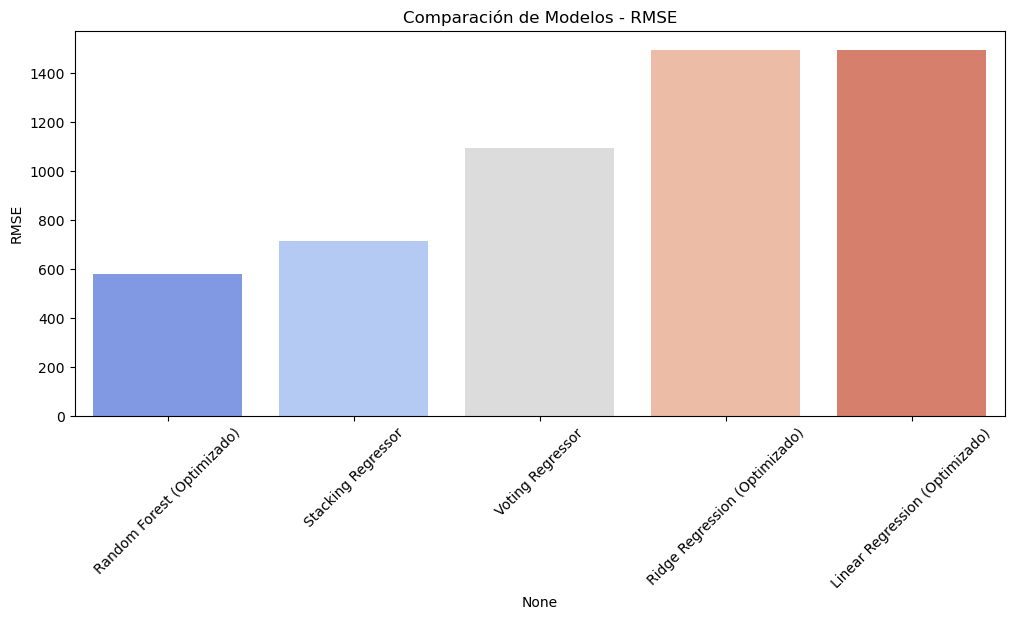

In [37]:
results_df = pd.DataFrame(results).T.sort_values(by='RMSE')

plt.figure(figsize=(12, 5))
sns.barplot(x=results_df.index, y=results_df["RMSE"], palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Comparación de Modelos - RMSE")
plt.ylabel("RMSE")
plt.show()

/var/folders/r1/bng466016psds6vp1_qcrgk40000gn/T/ipykernel_43656/1164774076.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette="coolwarm")


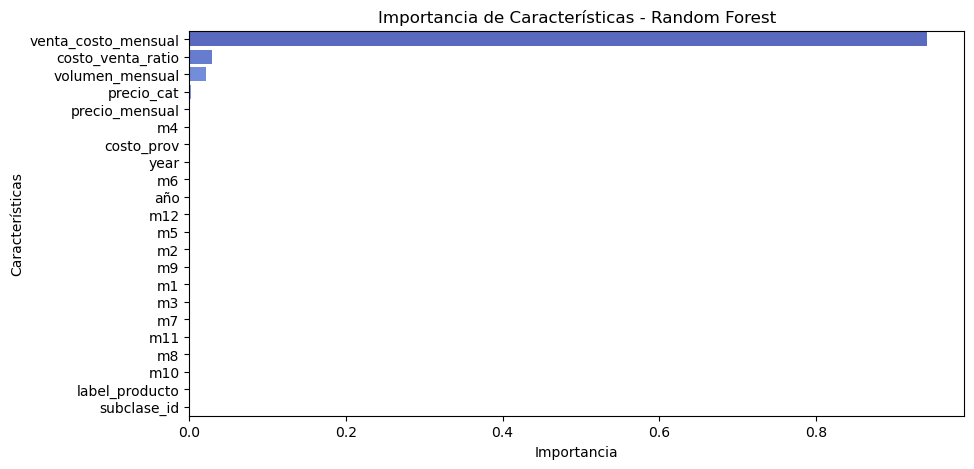

In [39]:
# Entrenar el modelo Random Forest con los mejores hiperparámetros


# Obtener la importancia de características
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Graficar la importancia de características
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances, y=feature_importances.index, palette="coolwarm")
plt.title("Importancia de Características - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()

# Evaluación de Modelos de Ensamble - RMSE

## Análisis de Resultados

### **Random Forest es el mejor modelo**
- Presenta el menor **RMSE**, lo que indica que tiene la mejor precisión entre los modelos evaluados.
- Como modelo basado en árboles de decisión, maneja bien relaciones no lineales y características irrelevantes.

### **Stacking Regressor mejora sobre Voting Regressor**
- El **Stacking Regressor** logra un RMSE más bajo que el **Voting Regressor**, lo que sugiere que la combinación de modelos con una segunda capa de predicción ayuda a mejorar el rendimiento.
- Esto indica que el modelo de **meta-aprendizaje** en Stacking es efectivo para corregir errores de los modelos base.

### **Voting Regressor no mejora significativamente**
- El **Voting Regressor** tiene un **RMSE mayor** que Stacking y Random Forest, lo que indica que la combinación de predicciones de modelos individuales no está funcionando tan bien como el aprendizaje en capas de Stacking.

###  **Las regresiones lineales tienen peor desempeño**
- **Linear Regression y Ridge Regression** presentan los peores **RMSE**, lo que sugiere que los datos tienen relaciones más complejas que no pueden ser bien modeladas solo con regresión lineal.
- Ridge, aunque regulariza el modelo, **no mejora lo suficiente**.
 
